# Skin Cancer Image Processing and Baseline Model

In [173]:
# Import Relevant Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers

import warnings
warnings.filterwarnings('ignore')

import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Activation, BatchNormalization

from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from keras import models
from keras import layers
np.random.seed(123)

In [3]:
!ls ../data

Additional_malignant
ISIC_2019_512x512
ISIC_2019_512x512.csv
ISIC_2019_Training_GroundTruth.csv
ISIC_2019_Training_Input
ISIC_2019_Training_Metadata.csv
ISIC_2020_Training_GroundTruth.csv
ISIC_2020_Training_JPEG
ISIC_FINAL_DATASET.csv
ISIC_FINAL_DATASET_512x512.csv
ISIC_IMAGES_512x512
add_train_malig_2.csv


In [6]:
# Reading in the final dataset from Data_Exploration.ipynb
df = pd.read_csv('../data/ISIC_FINAL_DATASET_512x512.csv')
df

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,path,source,ext
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,NaN,NaN
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,NaN,NaN
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,NaN,NaN
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,NaN,NaN
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38223,ISIC_0024302,-1,female,25.0,NaN,melanoma,malignant,1,29,3008,2000,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,2018 JID Editorial Images,jpg
38224,ISIC_0024303,-1,male,60.0,NaN,squamous cell carcinoma,malignant,1,29,3008,2000,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,2018 JID Editorial Images,jpg
38225,ISIC_0024304,-1,male,70.0,NaN,squamous cell carcinoma,malignant,1,29,3008,2000,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,2018 JID Editorial Images,jpg
38226,ISIC_0024305,-1,male,85.0,NaN,squamous cell carcinoma,malignant,1,29,4288,2848,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,2018 JID Editorial Images,jpg


- All images in the final dataset has size of 512x512.

In [18]:
df['benign_malignant'].value_counts()

benign       32542
malignant     5686
Name: benign_malignant, dtype: int64

In [143]:
df['target'].value_counts()

0    32542
1     5686
Name: target, dtype: int64

In [154]:
# Define X and y 
X = df[['image_name', 'path', 'sex', 'age_approx', 'anatom_site_general_challenge']]
y = df['benign_malignant']

In [155]:
X

,image_name,path,sex,age_approx,anatom_site_general_challenge
0,ISIC_2637011,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,45.0,head/neck
1,ISIC_0015719,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,45.0,upper extremity
2,ISIC_0052212,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,50.0,lower extremity
3,ISIC_0068279,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,45.0,head/neck
4,ISIC_0074268,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,55.0,upper extremity
...,...,...,...,...,...
38223,ISIC_0024302,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,female,25.0,NaN
38224,ISIC_0024303,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,male,60.0,NaN
38225,ISIC_0024304,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,male,70.0,NaN
38226,ISIC_0024305,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,male,85.0,NaN


In [156]:
# Train - Test Set Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [157]:
# Train - Validation set Split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [158]:
# Train dataframe
df_train = pd.concat([X_train, y_train], axis=1)
print(f"Train dataset: \n {df_train['benign_malignant'].value_counts()}")
df_train

Train dataset: 
 benign       23466
malignant     4058
Name: benign_malignant, dtype: int64


,image_name,path,sex,age_approx,anatom_site_general_challenge,benign_malignant
24359,ISIC_7393413,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,45.0,torso,benign
10998,ISIC_3392311,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,45.0,torso,benign
14078,ISIC_4319874,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,45.0,torso,benign
16697,ISIC_5106902,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,20.0,upper extremity,benign
13819,ISIC_4241907,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,60.0,NaN,benign
...,...,...,...,...,...,...
31284,ISIC_9454024,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,55.0,lower extremity,benign
21812,ISIC_6604551,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,35.0,NaN,benign
29,ISIC_0085172,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,50.0,lower extremity,benign
8476,ISIC_2644988,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,55.0,torso,benign


In [159]:
# Validation dataframe
df_val = pd.concat([X_val, y_val], axis=1)
print(f"Test dataset: \n {df_val['benign_malignant'].value_counts()}")
df_val

Test dataset: 
 benign       5842
malignant    1039
Name: benign_malignant, dtype: int64


,image_name,path,sex,age_approx,anatom_site_general_challenge,benign_malignant
32071,ISIC_9688534,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,45.0,lower extremity,benign
966,ISIC_0397464,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,70.0,upper extremity,benign
6842,ISIC_2144220,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,40.0,lower extremity,benign
21536,ISIC_6534818,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,70.0,lower extremity,benign
18511,ISIC_5623668,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,80.0,lower extremity,benign
...,...,...,...,...,...,...
37377,ISIC_0071388,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,male,70.0,head/neck,malignant
10173,ISIC_3152541,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,30.0,lower extremity,benign
14232,ISIC_4363603,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,45.0,head/neck,benign
33104,ISIC_9994390,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,65.0,lower extremity,benign


In [160]:
# Test (Holdout) dataframe:
df_test = pd.concat([X_test, y_test], axis=1)
print(f"Test dataset: \n {df_test['benign_malignant'].value_counts()}")
df_test

Test dataset: 
 benign       3234
malignant     589
Name: benign_malignant, dtype: int64


,image_name,path,sex,age_approx,anatom_site_general_challenge,benign_malignant
10115,ISIC_3135594,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,65.0,torso,benign
13314,ISIC_4087028,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,50.0,upper extremity,benign
198,ISIC_0177860,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,35.0,torso,benign
12365,ISIC_3805310,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,35.0,lower extremity,benign
4689,ISIC_1506954,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,30.0,lower extremity,benign
...,...,...,...,...,...,...
22755,ISIC_6912233,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,65.0,torso,benign
7528,ISIC_2354682,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,80.0,lower extremity,benign
22188,ISIC_6718737,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,70.0,head/neck,benign
36229,ISIC_0063109,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,male,80.0,head/neck,malignant


## Step 1: Baseline Model - Multi-layer Perceptron

In [174]:
# Instantiating a generator object and normalizing the RGB values:
generator = ImageDataGenerator(rescale=1./255)


# Creating the generator for the training data
train_generator = generator.flow_from_dataframe(df_train, x_col='path', y_col='benign_malignant',
                                                # Re-sizing images to 256x256
                                                target_size=(256, 256),
                                                seed=42,
                                                batch_size= int(len(df_train)/5),
                                                class_mode='binary')


# Creating the generator for the validation data
val_generator = generator.flow_from_dataframe(df_val, x_col='path', y_col='benign_malignant',
                                              # Re-sizing images to 256x256
                                              target_size=(256, 256),
                                              seed=42,
                                              batch_size= int(len(df_val)/5),
                                              class_mode='binary')


# Setting aside a testing/hold-out set
test_generator =  generator.flow_from_dataframe(df_test, x_col='path', y_col='benign_malignant',
                                                # Re-sizing images to 256x256
                                                target_size=(256, 256),
                                                seed=42,
                                                batch_size= int(len(df_test)/5),
                                                class_mode='binary')

Found 27524 validated image filenames belonging to 2 classes.
Found 6881 validated image filenames belonging to 2 classes.
Found 3823 validated image filenames belonging to 2 classes.


In [169]:
train_generator.class_indices

{'benign': 0, 'malignant': 1}

In [178]:
# Create the data sets
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

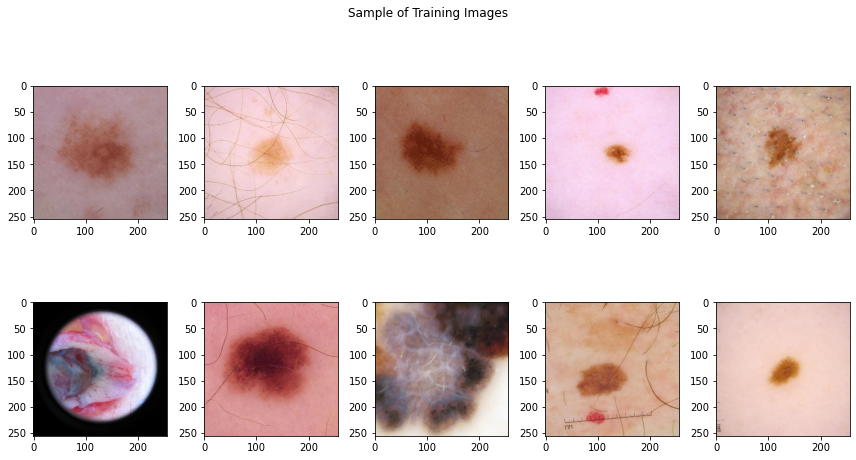

In [163]:
# Visualize sample of training images:
tr_batch = train_generator.next()
fig, axes = plt.subplots(2, 5, figsize=(12, 7))
    
for i in range(10):
    img = np.array(tr_batch[0][i] * 255, dtype='uint8') # Load image and rescale
    ax = axes[i // 5, i % 5]
    ax.imshow(img)

fig.suptitle('Sample of Training Images')
plt.tight_layout()
plt.show()


In [179]:
# Check classes
print(f"Train data set classes, {train_generator.class_indices}")
print(f"Validation data set classes, {val_generator.class_indices}")
print(f"Test data set classes, {test_generator.class_indices}")

Train data set classes, {'benign': 0, 'malignant': 1}
Validation data set classes, {'benign': 0, 'malignant': 1}
Test data set classes, {'benign': 0, 'malignant': 1}


In [180]:
# Explore dataset again
m_train = train_images.shape[0]
m_val = val_images.shape[0]
m_test = test_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of validation samples: " + str(m_val))
print ("Number of test samples: " + str(m_test))

print ("train_images shape: " + str(train_images.shape))   # batch_size=int(len(df_tr)/5) --> 27524/5 = 5504
print ("train_labels shape: " + str(train_labels.shape))

print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))

Number of training samples: 5504
Number of validation samples: 1376
Number of test samples: 764
train_images shape: (5504, 256, 256, 3)
train_labels shape: (5504,)
val_images shape: (1376, 256, 256, 3)
val_labels shape: (1376,)
test_images shape: (764, 256, 256, 3)
test_labels shape: (764,)


In [182]:
train_img = train_images.reshape(train_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)

print(train_img.shape)
print(val_img.shape)
print(test_img.shape)

(5504, 196608)
(1376, 196608)
(764, 196608)


In [199]:
train_y = np.reshape(train_labels, (train_img.shape[0], 1))
val_y = np.reshape(val_labels, (val_img.shape[0], 1))
test_y = np.reshape(test_labels, (test_img.shape[0], 1))

In [188]:
# Fit a Neural Network Model
model = models.Sequential()

# Adding layers
model.add(layers.Dense(20, activation='relu', input_shape=(196608,)))
model.add(layers.Dense(12, activation='relu')) # hidden layer
model.add(layers.Dense(1, activation='sigmoid')) # output layer

In [189]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 20)                3932180   
_________________________________________________________________
dense_18 (Dense)             (None, 12)                252       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 13        
Total params: 3,932,445
Trainable params: 3,932,445
Non-trainable params: 0
_________________________________________________________________


In [194]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
             metrics=['accuracy', 'Recall', 'Precision', 'AUC'])

history = model.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=100,  # mini batches of 100 units!
                    validation_data=(test_img, test_y))

Epoch 1/20
56/56 [==============================] - 3s 56ms/step - loss: 0.3121 - accuracy: 0.8821 - recall: 0.4009 - precision: 0.7238 - auc: 0.8519 - val_loss: 0.3822 - val_accuracy: 0.8704 - val_recall: 0.1885 - val_precision: 1.0000 - val_auc: 0.7633
Epoch 2/20
56/56 [==============================] - 3s 48ms/step - loss: 0.3619 - accuracy: 0.8661 - recall: 0.1472 - precision: 0.9922 - auc: 0.7946 - val_loss: 0.3857 - val_accuracy: 0.8743 - val_recall: 0.2131 - val_precision: 1.0000 - val_auc: 0.7770
Epoch 3/20
56/56 [==============================] - 3s 50ms/step - loss: 0.3525 - accuracy: 0.8668 - recall: 0.1518 - precision: 0.9924 - auc: 0.8131 - val_loss: 0.3552 - val_accuracy: 0.8743 - val_recall: 0.2131 - val_precision: 1.0000 - val_auc: 0.8081
Epoch 4/20
56/56 [==============================] - 3s 49ms/step - loss: 0.3039 - accuracy: 0.8835 - recall: 0.3302 - precision: 0.8190 - auc: 0.8648 - val_loss: 0.4215 - val_accuracy: 0.8861 - val_recall: 0.5328 - val_precision: 0.684

In [137]:
#history.history

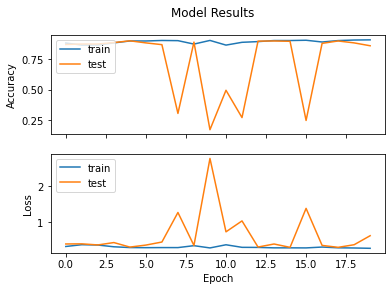

In [195]:
# Visualize the trainong results:
visualize_training_results(history)

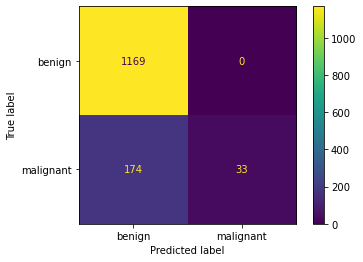

In [200]:
# Plot confusion matrix:
predictions = model.predict_classes(val_img)
cm = confusion_matrix(val_y, predictions, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign', 'malignant'])
disp.plot()
plt.show()

- We got 85% accuracy for training and 87% accuracy for validation set.

In [198]:
results_train = model.evaluate(train_img, train_y)
results_validation = model.evaluate(val_img, val_y)

results = pd.DataFrame(columns = ['Loss' , 'Accuracy', 'Recall', 'Precision', 'AUC'],
                      index = ['Train', 'Validation'])

for i in range(5):
    results[results.columns[i]]['Train'] = results_train[i]
    results[results.columns[i]]['Validation'] = results_validation[i]
    
results

43/43 [==============================] - 0s 9ms/step - loss: 0.5468 - accuracy: 0.8735 - recall: 0.1594 - precision: 1.0000 - auc: 0.8065


,Loss,Accuracy,Recall,Precision,AUC
Train,0.588539,0.85883,0.100811,0.988636,0.806509
Validation,0.54681,0.873547,0.15942,1,0.806451
